# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных была сделана в проекте «Статистический анализ данных».

Построим модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке.

# Цели и задачи проекта

**Цели:**

Провести исследование с целью предложить пользователям новый тариф «Смарт» или «Ультра» на основании их поведения. 

Результаты исследования позволят специалистам выбрать самую качественную модель, которая выберет подходящий тариф.

**Задачи:**

1. Откроем файл с данными и изучим его.
2. Разделим исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследуем качество разных моделей, меняя гиперпараметры. Кратко напишем выводы исследования.
4. Проверим качество модели на тестовой выборке.
5. Дополнительное задание: проверим модели на вменяемость.

В ходе проведения исследования нам необходимо проверить несколько гипотез:

- Гипотеза 1: самая качественная модель на валидационной выборке - "случайный лес";
- Гипотеза 2: максимальное значение метрики качества наилучшей модели (accuracy) больше 0,75.

# Описание данных

Входные данные – данные о поведении клиентов, которые уже перешли на эти тарифы. 

Путь к файлу: `/datasets/users_behavior.csv`.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# План работы

1. Откроем и изучим файл
2. Разобьём данные на выборки
3. Исследуем модели
4. Проверим модель на тестовой выборке
5. (бонус) Проверим модели на адекватность
6. Общий вывод

## Откроем и изучим файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv(r'C:/Users/lorad/OneDrive/Documents/Моя папка/Data Science/Мои проекты/GitHubRepositories/'
                 'YandexPracticum/04_project_work_introduction_to_ML_recommendation_of_tariffs/users_behavior.csv')
display(df.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


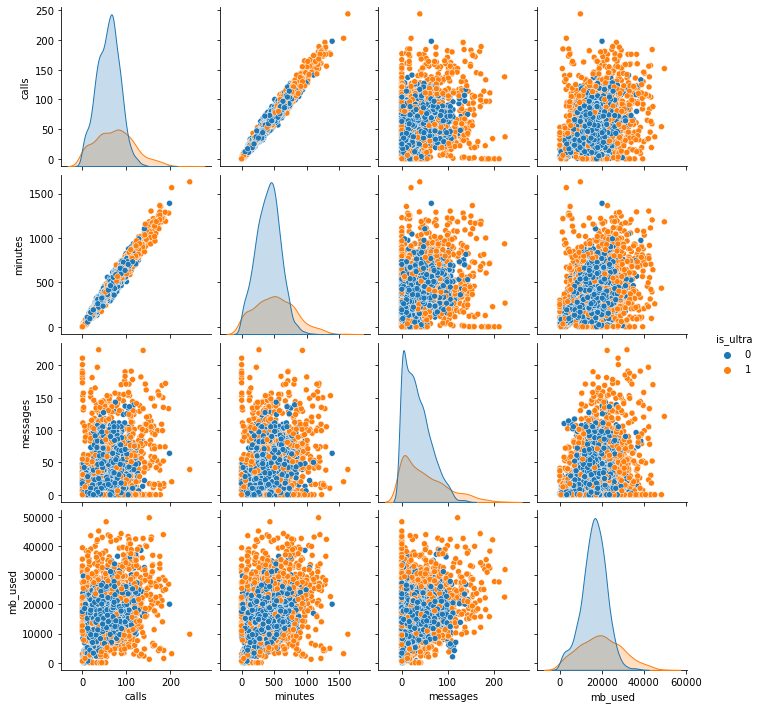

In [3]:
# Проверим датафрейм на мультиколлинеарность

import seaborn as sns
sns.pairplot(df, hue='is_ultra')

In [4]:
# Чтобы избавиться от мультиколлинеарности между столбцами calls и minutes, удалим столбец minutes из датафрейма

df_multi = df.drop('minutes', axis=1)
df_multi.head(10)

,calls,messages,mb_used,is_ultra
0,40.0,83.0,19915.42,0
1,85.0,56.0,22696.96,0
2,77.0,86.0,21060.45,0
3,106.0,81.0,8437.39,1
4,66.0,1.0,14502.75,0
5,58.0,21.0,15823.37,0
6,57.0,20.0,3738.90,1
7,15.0,6.0,21911.60,0
8,7.0,3.0,2538.67,1
9,90.0,38.0,17358.61,0


In [5]:
# Проверим датасет на сбалансированность классов в таргете:

df_multi['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Значений "0" почти в 2 раза больше, чем значений "1". Это означает, что датасет несбалансирован: пользователи в течение месяца использовали тариф «Смарт» в 2 раза больше, чем тариф «Ультра».

## Разобьём данные на выборки

In [6]:
# Разделим исходные данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1.
# Для корректного разбиения датасетов применим аргумент stratify.

# Сначала выделим из исходных данных df_multi тестовую выборку df_test (20%).
df_train_valid, df_test = train_test_split(df_multi, test_size=0.20, random_state=12345, stratify=df_multi['is_ultra'])

# Затем выделим из оставшихся данных df_train_valid обучающую и валидационную выборки 
# (20% от исходных данных df_multi = 25% от оставшихся df_train_valid).
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=12345, stratify=df_train_valid['is_ultra'])

# Сохраним признаки в отдельных переменных:
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

In [7]:
# Проверим корректность разбиения датасетов:

print(f'Тестовая выборка составляет: {df_test.shape[0]/df_multi.shape[0]*100} % от исходного датасета df_multi')
print(f'Валидационная выборка составляет: {df_valid.shape[0]/df_multi.shape[0]*100} % от исходного датасета df_multi')
print(f'Валидационная выборка составляет: {df_valid.shape[0]/df_train_valid.shape[0]*100} % от датасета df_train_valid')

Тестовая выборка составляет: 20.00622277535781 % от исходного датасета df_multi
Валидационная выборка составляет: 20.00622277535781 % от исходного датасета df_multi
Валидационная выборка составляет: 25.009723842862698 % от датасета df_train_valid


## Исследуем модели

In [8]:
# Исследуем качество разных моделей, меняя гиперпараметры. Кратко напишем выводы исследования.

# Классифицируем валидационные данные с помощью модели 'дерево решений'.
# А также для последующего построения графиков зависимости значений метрик качества моделей accuracy 
# от глубины дерева max_depth на обучающей и валидационной выборках создадим следующие списки:
# depth_dt - с глубиной дерева max_depth, 
# accuracy_train_dt - с качеством модели accuracy (долей правильных ответов) на обучающей выборке,
# accuracy_valid_dt - с качеством модели accuracy (долей правильных ответов) на валидационной выборке
# (окончание _dt - сокращение от 'decision tree').

# Настроим гиперпараметры модели 'дерево решений' и сделаем цикл для max_depth от 1 до 10:
best_model = None
model_depth_four = None  # переменная для модели с depth=4 (для последующего построения дерева решений)
best_depth = 0
best_result = 0
depth_dt = []
accuracy_train_dt = []
accuracy_valid_dt = []
for depth in range(1, 11):
    # создадим модель 'дерево решений' model_dt, указав максимально допустимую глубину дерева max_depth=depth:
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train) # обучим модель на обучающей выборке
    result_train = model_dt.score(features_train, target_train) # посчитаем качество модели на обучающей выборке
    result_valid = model_dt.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
    depth_dt.append(depth) # список с глубиной дерева max_depth 
    accuracy_train_dt.append(result_train) # список с качеством модели accuracy на обучающей выборке
    accuracy_valid_dt.append(result_valid) # список с качеством модели accuracy на валидационной выборке
    if result_valid > best_result:
        best_model = model_dt # сохраним наилучшую модель
        best_depth = depth # сохраним наилучшее значение гиперпараметра max_depth на валидационной выборке
        # сохраним наилучшее значение метрики accuracy (доля правильных ответов) на валидационной выборке
        best_result = result_valid
    elif depth == 4:
        model_depth_four = model_dt # сохраним модель с depth=4 (для последующего построения дерева решений)
        
print('Наилучшая модель "дерево решений" на валидационной выборке:', best_model)
print('Глубина дерева наилучшей модели "дерево решений" на валидационной выборке:', best_depth)
print('Accuracy наилучшей модели "дерево решений" на валидационной выборке:', best_result)

Наилучшая модель "дерево решений" на валидационной выборке: DecisionTreeClassifier(max_depth=5, random_state=12345)
Глубина дерева наилучшей модели "дерево решений" на валидационной выборке: 5
Accuracy наилучшей модели "дерево решений" на валидационной выборке: 0.8040435458786936


Наилучшая модель "дерево решений" на валидационной выборке имеет accuracy = 0.8040435458786936 при глубине дерева depth = 5.

In [9]:
# Выведем полученные списки depth_dt, accuracy_train_dt и accuracy_valid_dt.

# Список с глубиной дерева max_depth:
depth_dt

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [10]:
# Список с качеством модели accuracy на обучающей выборке:
accuracy_train_dt

[0.7520746887966805,
 0.779045643153527,
 0.7914937759336099,
 0.7951244813278008,
 0.8148340248962656,
 0.8283195020746889,
 0.8407676348547718,
 0.8526970954356846,
 0.8682572614107884,
 0.8801867219917012]

In [11]:
# Список с качеством модели accuracy на валидационной выборке:
accuracy_valid_dt

[0.7589424572317263,
 0.7822706065318819,
 0.80248833592535,
 0.8009331259720062,
 0.8040435458786936,
 0.7947122861586314,
 0.7978227060653188,
 0.7993779160186625,
 0.8040435458786936,
 0.7978227060653188]

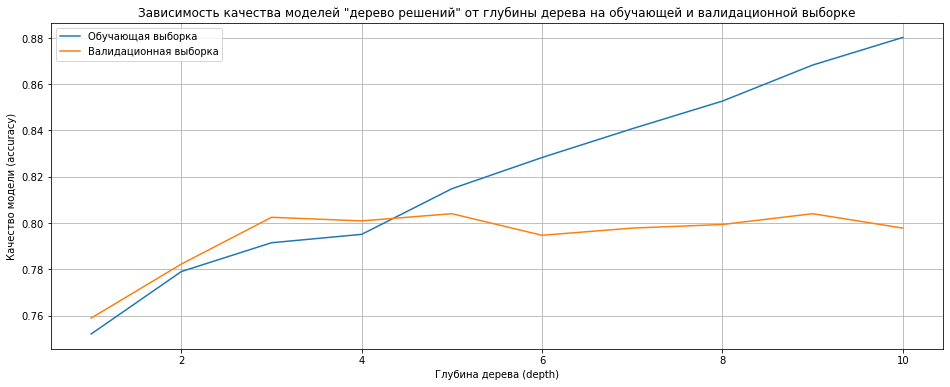

In [12]:
# Построим график зависимости качества моделей "дерево решений" от глубины дерева на обучающей и валидационной выборках:

plt.figure(figsize=(16, 6))
plt.grid(True)
plt.plot(depth_dt, accuracy_train_dt)
plt.plot(depth_dt, accuracy_valid_dt)
plt.legend(['Обучающая выборка', 'Валидационная выборка'])
plt.xlabel('Глубина дерева (depth)')
plt.ylabel('Качество модели (accuracy)')
plt.title('Зависимость качества моделей "дерево решений" от глубины дерева на обучающей и валидационной выборке')
plt.show()

На графике видно, что переобучение наступает при глубине дерева max_depth=4-5. Т.е. в качестве лучшего параметра max_depth лучше выбрать 4.

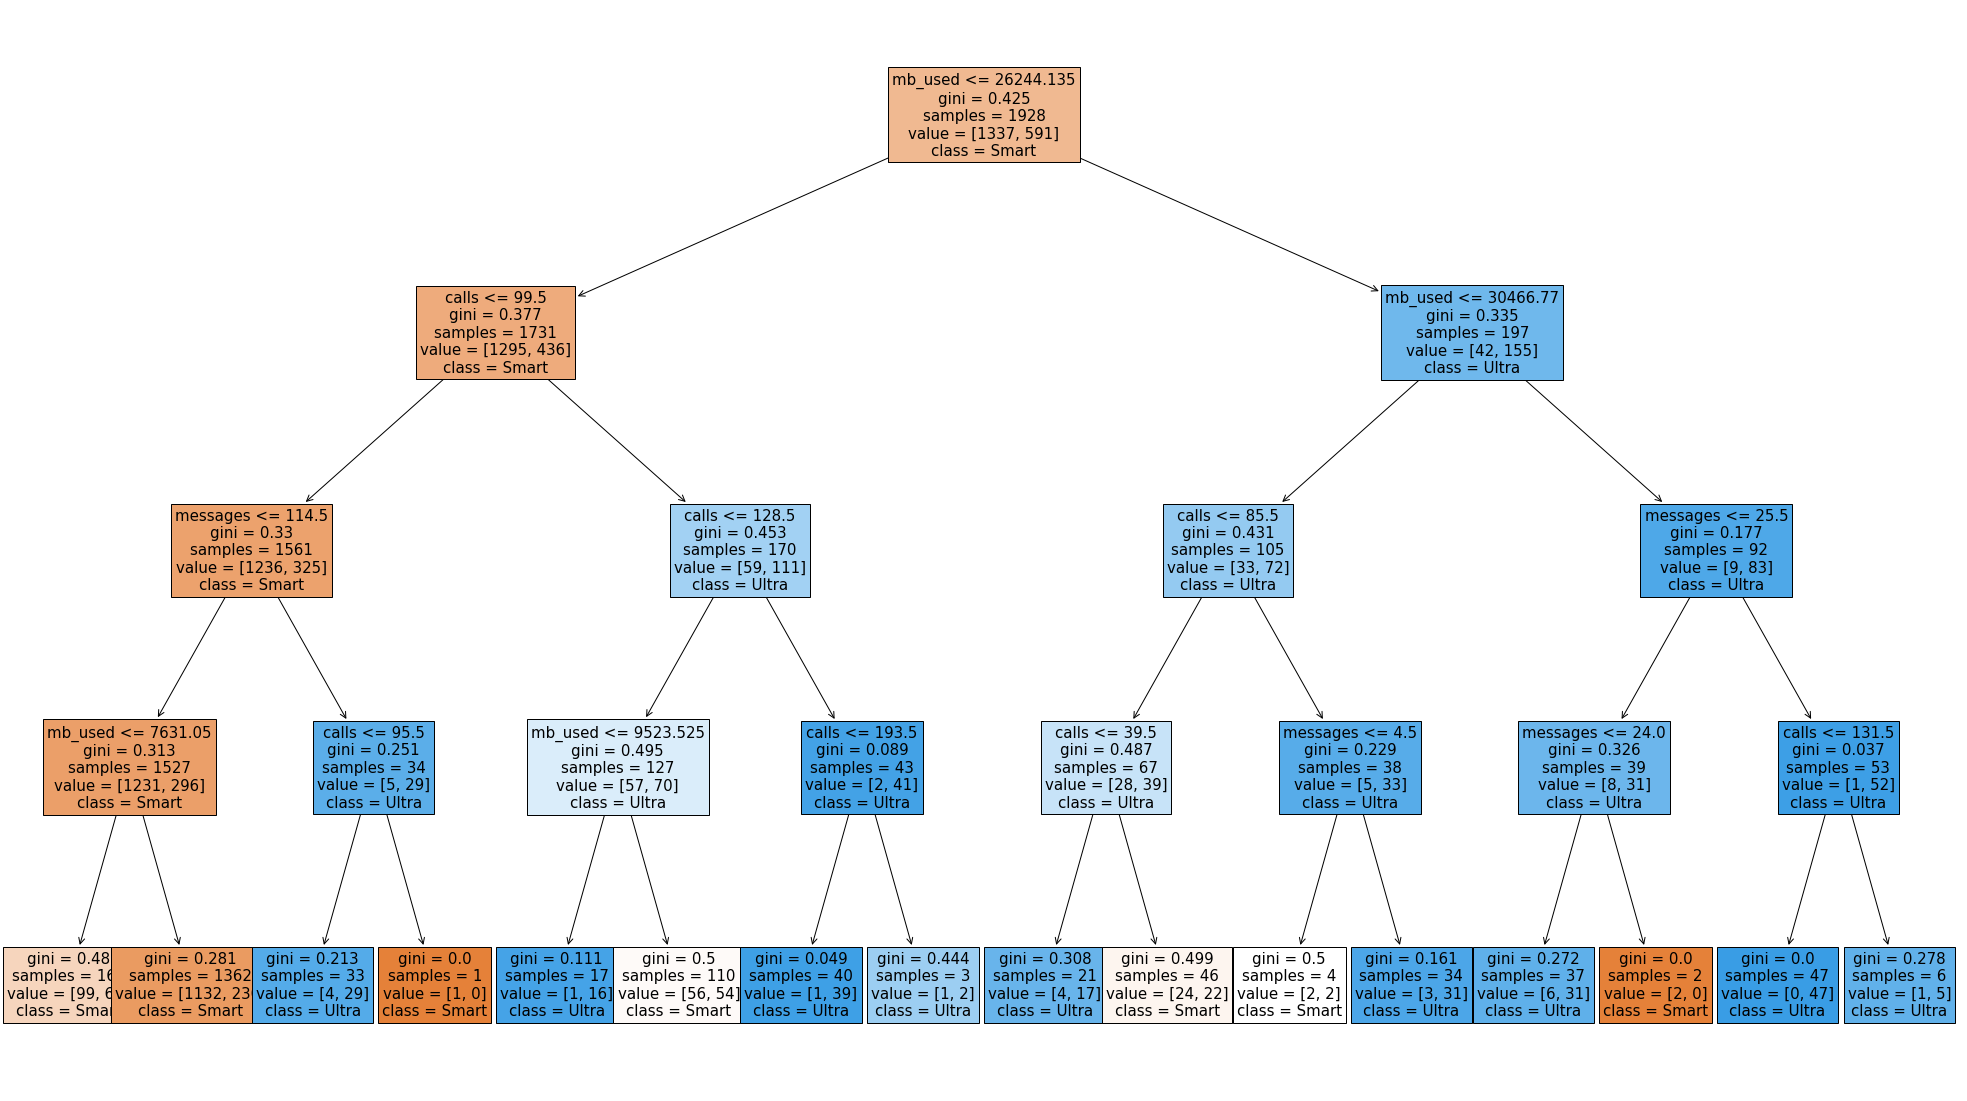

In [13]:
# Построим деревья решений для моделей model_depth_four и best_model при помощи функции plot_tree.

# Дерево решений для модели model_depth_four (модель c depth=4):
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(model_depth_four, 
                   feature_names=features_train.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 15)

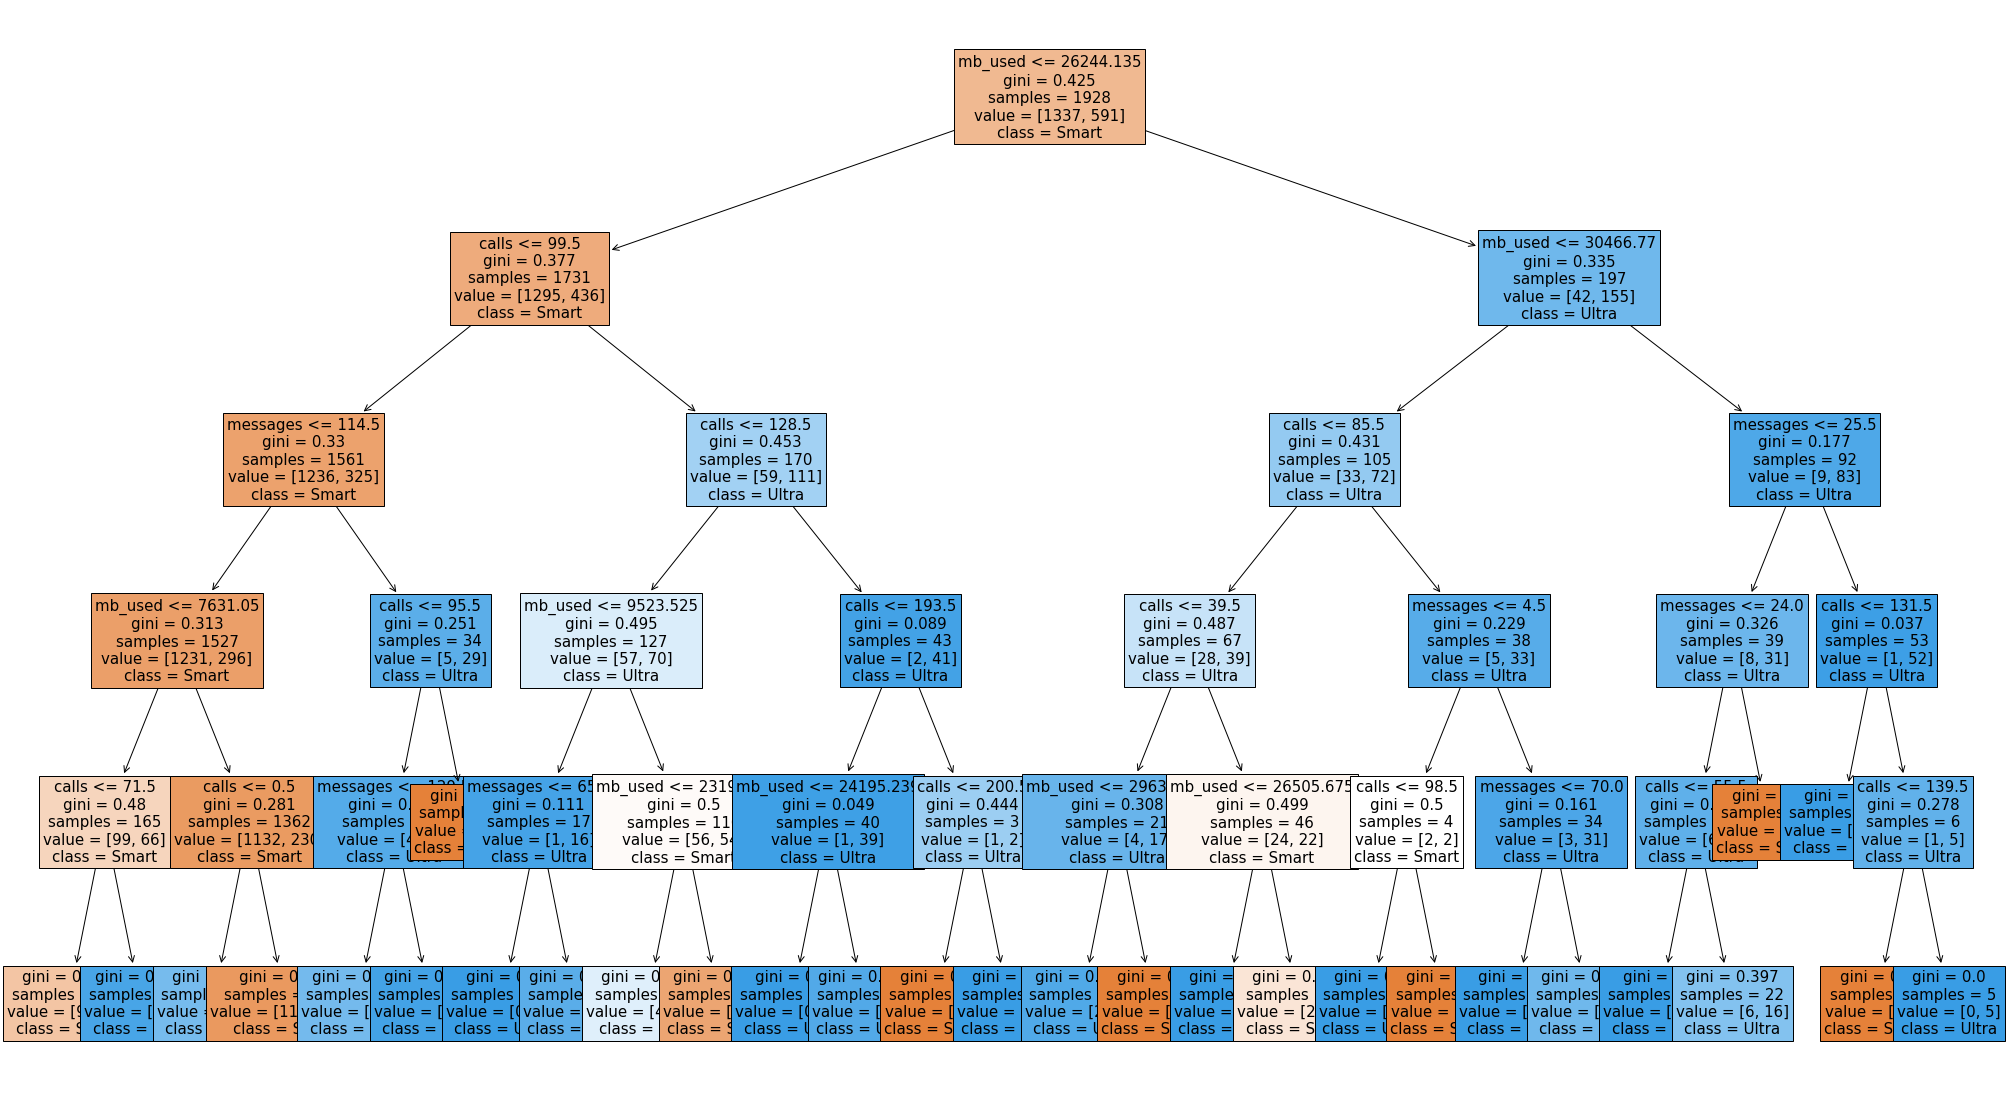

In [14]:
# Дерево решений для модели best_model (модель с самой высокой метрикой accuracy):
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model, 
                   feature_names=features_train.columns.values, 
                   class_names=['Smart','Ultra'],
                   filled=True,
                   fontsize = 15)

In [15]:
%%time
# С помощью команды %%time можно вывести время, затраченное на выполнение ячейки.


# Классифицируем валидационные данные с помощью модели 'случайный лес'
# (окончание _rf - сокращение от 'random forest'):

# Настроим гиперпараметры модели 'случайный лес' и сделаем цикл для n_estimators и max_depth от 1 до 10:
best_model = None
best_est = 0
best_depth = 0
best_result = 0
for est in range(1, 11):
    for depth in range (1, 11):
        # создадим модель 'случайный лес' с заданным количеством деревьев и глубиной дерева:
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train) # обучим модель на обучающей выборке
        result = model_rf.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
        if result > best_result:
            best_model = model_rf # сохраним наилучшую модель
            best_est = est # сохраним наилучшее значение гиперпараметра n_estimators на валидационной выборке
            best_depth = depth # сохраним наилучшее значение гиперпараметра max_depth на валидационной выборке
            best_result = result # сохраним наилучшее значение метрики accuracy на валидационной выборке
            
print('Наилучшая модель "случайный лес" на валидационной выборке:', best_model)
print('Количество деревьев наилучшей модели "случайный лес" на валидационной выборке:', best_est)
print('Глубина дерева наилучшей модели "случайный лес" на валидационной выборке:', best_depth)
print('Accuracy наилучшей модели "случайный лес" на валидационной выборке:', best_result)

Наилучшая модель "случайный лес" на валидационной выборке: RandomForestClassifier(max_depth=9, n_estimators=9, random_state=12345)
Количество деревьев наилучшей модели "случайный лес" на валидационной выборке: 9
Глубина дерева наилучшей модели "случайный лес" на валидационной выборке: 9
Accuracy наилучшей модели "случайный лес" на валидационной выборке: 0.8304821150855366
CPU times: total: 1.11 s
Wall time: 1.08 s


Наилучшая модель "случайный лес" на валидационной выборке имеет accuracy = 0.8304821150855366 при количестве деревьев est = 9 и глубине дерева depth = 9.

Качество модели "случайный лес" на валидационной выборке выше, чем у модели "дерево решений".

In [16]:
# Библиотека tqdm позволяет наглядно проиллюстрировать ход выполнения программы.
# Я решила не убирать эту библиотеку в отдельную строку для импортов вверху ноутбука, т.к. это - отдельная "фишка".

# Первый вариант применения tqdm:
import time
from tqdm import tqdm

mylist = [1,2,3,4,5,6,7,8]

for i in tqdm(mylist):
    time.sleep(1)

100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


In [17]:
# Второй вариант применения tqdm:
from tqdm import tqdm

for i in tqdm (range (100), desc='Loading...'):
    pass

Loading...: 100%|██████████| 100/100 [00:00<?, ?it/s]


In [18]:
%%time

# Для выведения лучшей модели 'случайный лес', а также её гиперпараметров и метрики accuracy 
# можно также использовать функционал GridSearchCV.
# Для построения модели используем те же значения гиперпараметров, что и в прошлый раз.

# GridSearchCV применяется к набору данных df_train_valid, оставшихся после выделения из исходных данных 
# тестовой выборки df_test (20%). В качестве исходных данных мы можем использовать датафрейм df_multi,
# полученный после избавления первоначального датафрейма df от мультиколлинеарности.

# Сначала сохраним признаки для датафрейма df_train_valid в отдельных переменных:
features_train_valid = df_train_valid.drop('is_ultra', axis=1)
target_train_valid = df_train_valid['is_ultra']

rf = RandomForestClassifier(random_state=12345) # создадим модель 'случайный лес' rf

parameters = {'n_estimators': range (1, 11),
              'max_depth': range (1, 11)} # отдельно создадим словарь с гиперпараметрами n_estimators и max_depth

# создадим модель model_grid при помощи функционала GridSearchCV с кроссвалидацией cv = 5:
model_grid = GridSearchCV(rf, parameters, cv=5) 
model_grid.fit(features_train_valid, target_train_valid) # обучим модель model_grid на обучающей выборке

model_grid.best_estimator_ # наилучшая модель 'случайный лес'

CPU times: total: 6.28 s
Wall time: 6.33 s


RandomForestClassifier(max_depth=8, n_estimators=10, random_state=12345)

In [19]:
model_grid.best_params_ # глубина дерева и количество деревьев наилучшей модели 'случайный лес'

{'max_depth': 8, 'n_estimators': 10}

In [20]:
model_grid.best_score_ # метрика качества accuracy наилучшей модели 'случайный лес'

0.8063103018397492

При использовании функционала GridSearchCV наилучшая модель "случайный лес" имеет accuracy = 0.8063103018397492 при количестве деревьев est = 10 и глубине дерева depth = 8.

Таким образом, функционал GridSearchCV в качестве наилучшей вывел менее качественную модель "случайный лес" по сравнению с использованием цикла `for`.

In [21]:
# Классифицируем валидационные данные с помощью модели 'логистическая регрессия'
# (окончание _lr - сокращение от 'logistic regression'):

model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model_lr.fit(features_train, target_train) 
model_lr.score(features_valid, target_valid) 

print("Accuracy модели 'логистическая регрессия' на валидационной выборке:", model_lr.score(features_valid, target_valid))

Accuracy модели 'логистическая регрессия' на валидационной выборке: 0.7060653188180405


Качество модели "логистическая регрессия" на валидационной выборке ниже, чем у моделей "дерево решений" и "случайный лес".

Итак, на валидационной выборке по качеству лидирует модель "случайный лес".

## Проверим модель на тестовой выборке

На данном этапе необходмио проверить качество модели на тестовой выборке.

В пункте 3 "Исследуйте модели" мы выяснили, что наилучшей моделью машинного обучения для нашего датасета является "случайный лес". Мы обучали эту модель двумя способами и получили разные значения метрики качества и гиперпараметров:

- при помощи цикла `for` (accuracy = 0.8304821150855366, est = 9, depth = 9),
- при помощи функционала GridSearchCV (accuracy = 0.8063103018397492, est = 10, depth = 8).

Функционал GridSearchCV в качестве наилучшей вывел менее качественную модель "случайный лес" по сравнению с использованием цикла `for`.

Тем не менее, проверим качество модели 'случайный лес' для обоих случаев.


In [22]:
# Проверим на тестовой выборке качество модели 'случайный лес' model_rf, полученной при помощи цикла for:

predictions_test_rf = model_rf.predict(features_test) # найдём предсказания на тестовой выборке
accuracy_rf = accuracy_score(target_test, predictions_test_rf) # вычислим долю правильных ответов
print("Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью цикла for:", accuracy_rf)

Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью цикла for: 0.7869362363919129


In [23]:
# Проверим на тестовой выборке качество модели 'случайный лес' model_grid, полученной при помощи функционала GridSearchCV:

predictions_test_grid = model_grid.predict(features_test) # найдём предсказания на тестовой выборке
accuracy_grid = accuracy_score(target_test, predictions_test_grid) # вычислим долю правильных ответов
print("Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью GridSearchCV:", accuracy_grid)

Доля правильных ответов accuracy в модели 'случайный лес', полученной с помощью GridSearchCV: 0.7978227060653188


Таким образом, в обоих случаях доля правильных ответов в модели 'случайный лес' превышает 0,75 - изначально поставленное в задании условие.

Доля правильных ответов accuracy, полученных с помощью цикла for, составляет:
- 0.8304821150855366 - для валидационной выборки,
- 0.7869362363919129 - для тестовой выборки.

Т.е. здесь присутствует эффект переобучения (результат на тестовой выборке хуже, чем на валидационной).


Доля правильных ответов accuracy, полученных с помощью функционала GridSearchCV, составляет:
- 0.8063103018397492 - для валидационной выборки,
- 0.7978227060653188 - для тестовой выборки.

Использование функционала GridSearchCV для построения модели показало гораздо лучший результат.

## (бонус) Проверим модели на адекватность

In [24]:
# Дополнительное задание: проверим модели на вменяемость. 
# Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. 
# В следующем курсе подробнее об этом расскажем.

In [25]:
# Напомним, что датасет df_multi не сбалансирован в таргете:

df_multi['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [26]:
# Проверим модели на вменяемость:

model_dummy = DummyClassifier(strategy='most_frequent', random_state=12345) # создадим модель model_dummy
model_dummy.fit(features_train, target_train) # обучим модель model_dummy на обучающей выборке
model_dummy.predict(features_test)
accuracy_dummy = model_dummy.score(features_test, target_test) # посчитаем качество модели на тестовой выборке
print(f'Наивный прогноз самого частого класса ("0"): {accuracy_dummy:.2%}')

Наивный прогноз самого частого класса ("0"): 69.36%


Наивный прогноз самого частого класса ("0") составляет 69,36%, что гораздо ниже полученных значений метрик качества моделей (accuracy). Поэтому модели можно считать вменяемыми.

## Общий вывод

Проведено исследование с целью предложить пользователям новый тариф «Смарт» или «Ультра» на основании их поведения. 

Входные данные – данные о поведении клиентов, которые уже перешли на эти тарифы.

Результаты исследования позволят специалистам выбрать самую качественную модель, которая выберет подходящий тариф.

Перед проведением исследования были сформулированы несколько гипотез:

- Гипотеза 1: самая качественная модель на валидационной выборке - "случайный лес";
- Гипотеза 2: максимальное значение метрики качества наилучшей модели (accuracy) больше 0,75.

В результате удалось выявить следующие зависимости.

<b>Гипотеза 1 подтверждена:</b>

На валидационной выборке:
- 0.8040435458786936 - accuracy модели "дерево решений";
- 0.8304821150855366 - accuracy модели "случайный лес", построенной при помощи цикла for;
- 0.8063103018397492 - accuracy модели "случайный лес", построенной при помощи функционала GridSearchCV;
- 0.7060653188180405 - accuracy модели "логистическая регрессия".

Рекомендация: самой качественной моделью является "случайный лес". Функционал GridSearchCV в качестве наилучшей вывел менее качественную модель "случайный лес" по сравнению с использованием цикла `for`. 

<b>Гипотеза 2 подтверждена:</b>

Доля правильных ответов accuracy модели "случайный лес", полученных с помощью цикла for, составляет:
- 0.8304821150855366 - для валидационной выборки,
- 0.7869362363919129 - для тестовой выборки.

Т.е. здесь присутствует эффект переобучения (результат на тестовой выборке хуже, чем на валидационной).

Доля правильных ответов accuracy модели "случайный лес", полученных с помощью функционала GridSearchCV, составляет:
- 0.8063103018397492 - для валидационной выборки,
- 0.7978227060653188 - для тестовой выборки.

Использование функционала GridSearchCV для построения модели показало гораздо лучший результат.

Рекомендация: доля правильных ответов для тестовой выборки превышает 0,75 у обеих моделей "случайный лес". Но лучший результат показывает модель, обученаая при помощи Функционала GridSearchCV.

<b>Общие рекомендации:</b>

Специалистам, которые занимаются исследованием поведения пользователей и планированием увеличения прибыли, можно использовать зависимости из обеих гипотез 1 и 2.